In [2]:
#Minimal Garch implementation
import pandas as pd
import numpy as np
import yfinance as yf #stock api
from scipy import stats #tests
from arch import arch_model #arch models
import pmdarima as pm #arma models
import statsmodels.api as sm
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
#Load data

start = '2000-09-02'
end = '2021-07-02'

ticker_adjclose = yf.download('SPY', period = "ytd", start = start, group_by = 'ticker',auto_adjust=True, threads = True) #Get a stock

[*********************100%***********************]  1 of 1 completed


In [4]:
#Get the returns. Raw prices may have unit root.
ticker_diff = ticker_adjclose['Close'].diff().dropna()  #1st difference
returns = ticker_adjclose['Close'].pct_change().dropna()#linear return
returns_log_tot = np.log(1+returns).dropna()*100        #log return
returns_log = returns_log_tot[:end]                     #log returns for training

In [5]:
#Descriptive statistics and the Dickey-Fuller test with trend and drift.
print(stats.moment(returns_log, moment = [1,2,3,4])) #--> skewed?
print(sm.tsa.stattools.adfuller(returns_log)) #--> No unit root on log returns

[ 0.          1.53088264 -0.53175341 36.08252463]
(-17.4126095380501, 4.876204789232457e-30, 17, 5221, {'1%': -3.4316031158795095, '5%': -2.862093746873135, '10%': -2.5670647592452664}, 16886.502023952304)


In [6]:
#Funtion for visualizing data
def ts_graph(ts,ts_index):
    #Input an array!
    fig, axes = plt.subplots(2, 3, figsize = (25,10))
    fig.suptitle('Graphs')

    sns.lineplot(x =ts_index, y = ts, ax = axes[0,0])
    axes[0,0].set_title('Time series')

    sns.distplot(ts, ax=axes[0,1])
    axes[0,1].set_title('Distribution')

    stats.probplot(x =ts, plot = axes[0,2])

    plot_acf(ts, title='ACF', ax = axes[1,0])
    
    plot_pacf(ts, title='PACF', ax = axes[1,1])

    plt.show()


C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


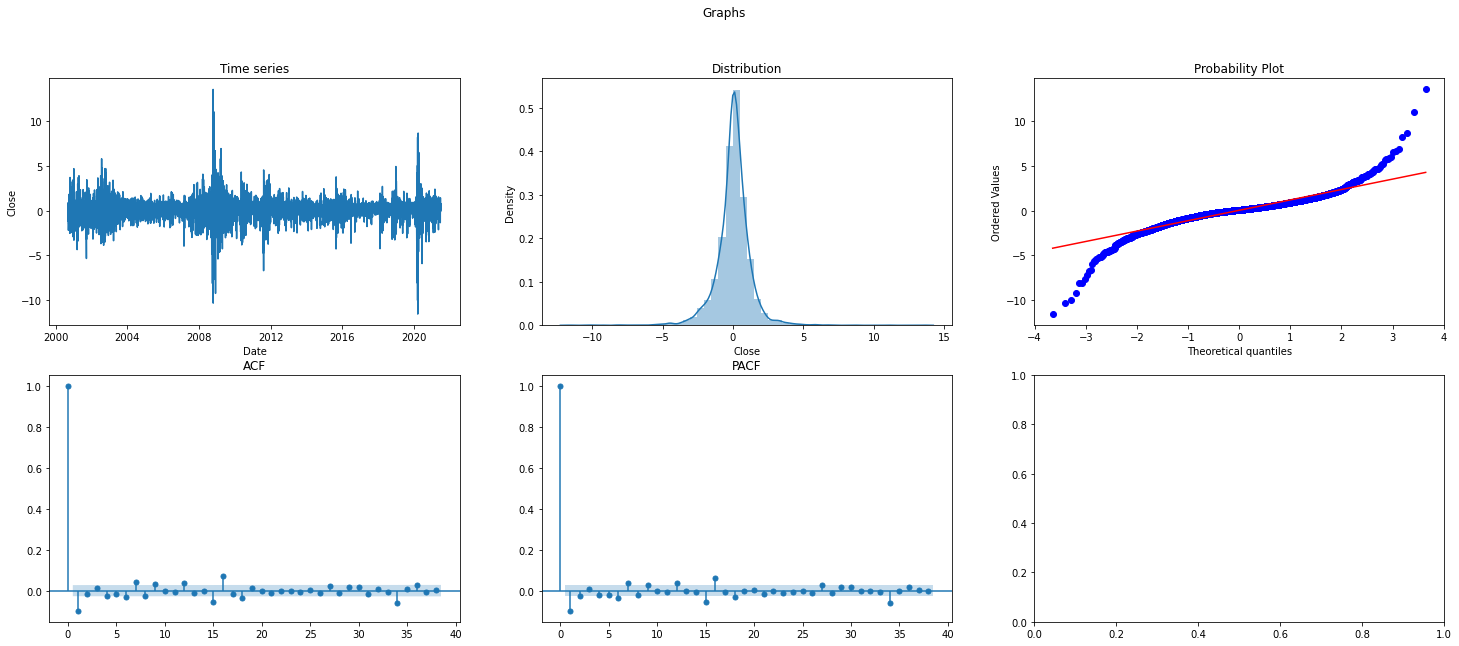

In [7]:
#Graphs

ts_graph(returns_log,returns_log.index) 
#Heavy tails --> skewed t-student? (2,2) model?
#Volatility clusters --> GARCH model?


C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


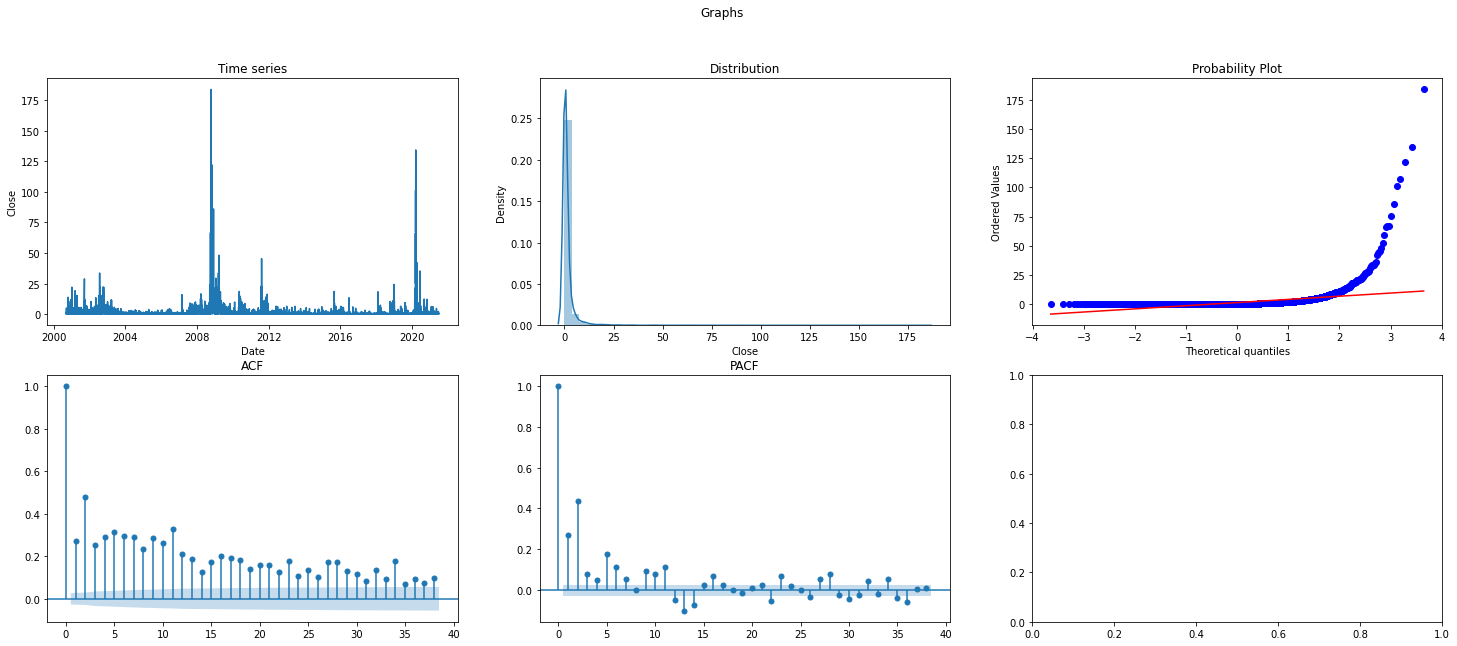

In [8]:
#Graphing for GARCH analisis

ts_graph(returns_log**2,returns_log.index) 
#(3,3) model?

## Implementing basic GARCH model

In [9]:
#Specify Model
garchm = arch_model(returns_log,p = 2, q = 1, mean = 'Constant', vol = 'GARCH', dist = 'skewt') #best aic

#fit model
garchm_result = garchm.fit(disp = 'off')

#Display model results
print(garchm_result.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -6960.74
Distribution:      Standardized Skew Student's t   AIC:                           13935.5
Method:                       Maximum Likelihood   BIC:                           13981.4
                                                   No. Observations:                 5239
Date:                           Tue, Sep 07 2021   Df Residuals:                     5238
Time:                                   16:24:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


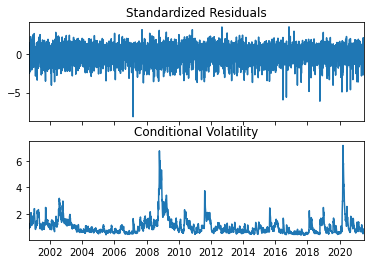

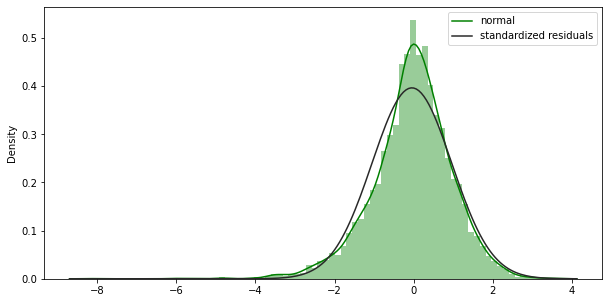

In [10]:
#Check residuals and volatility
garchm_resid = garchm_result.resid
garchm_std =  garchm_result.conditional_volatility

#Standardized residuals
garchm_std_resid = garchm_resid/garchm_std

#Plot Residuals and volatility
garchm_result.plot()

#Plot the histogram of the standardized residuals
plt.figure(figsize=(10,5))
sns.distplot(garchm_std_resid, norm_hist=True, fit=stats.norm, bins=80, color='g')
plt.legend(('normal', 'standardized residuals'))
plt.show()


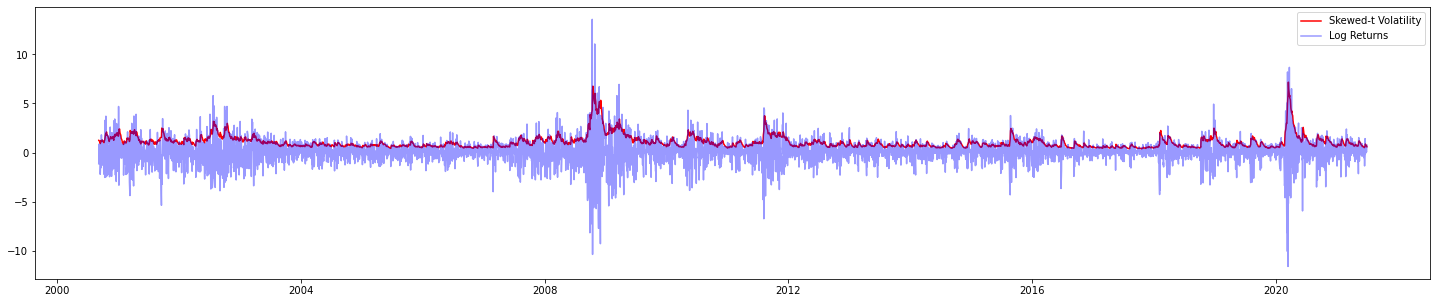

In [11]:
# Plot model fitting results
plt.figure(figsize=(25,5))
plt.plot(garchm_std, color = 'red', label = 'Skewed-t Volatility')
plt.plot(returns_log, color = 'blue', label = 'Log Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [12]:
#Rolling Forecast
rolling_predictions = []
test_size = 60

for i in range(test_size):
    train = returns_log_tot[:-(test_size-i)]
    model = arch_model(train, p=2, q=1, mean = 'Constant', vol = 'GARCH', dist = 'skewt')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-60:])

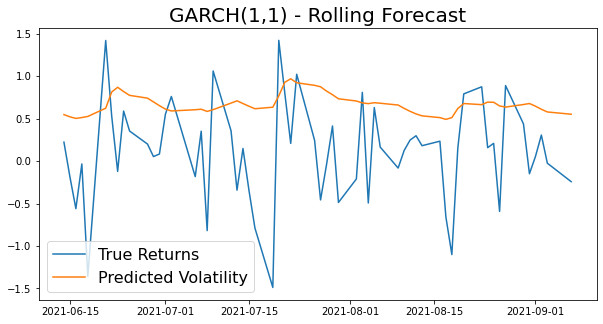

In [13]:
plt.figure(figsize=(10,5))
true, = plt.plot(returns_log_tot[-60:])
preds, = plt.plot(rolling_predictions)
plt.title('GARCH(1,1) - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

#This model is as bad as it gets...

In [14]:
##More complex model:
#ARMA model for log returns
model = pm.auto_arima(returns_log, d = 0, start_p=1, start_q=1, max_p=4 ,max_q=4, seasonal=False, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=17054.787, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=17103.251, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=17055.955, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17053.880, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=17054.695, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=17052.094, Time=0.81 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=17053.742, Time=1.37 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=17053.852, Time=1.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=17056.384, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=17051.755, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=17054.430, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=17053.746, Time=1.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=17055.962, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=17054.131, Time=1.54 sec
 ARIMA(2,0,1)(0,0,0

In [15]:
#Fit best model
returns_log.index = pd.DatetimeIndex(returns_log.index) #Necessary for pmdarima to work

model_arma = sm.tsa.SARIMAX(returns_log, order = (2,0,1))
model_arma_result = model_arma.fit()

C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


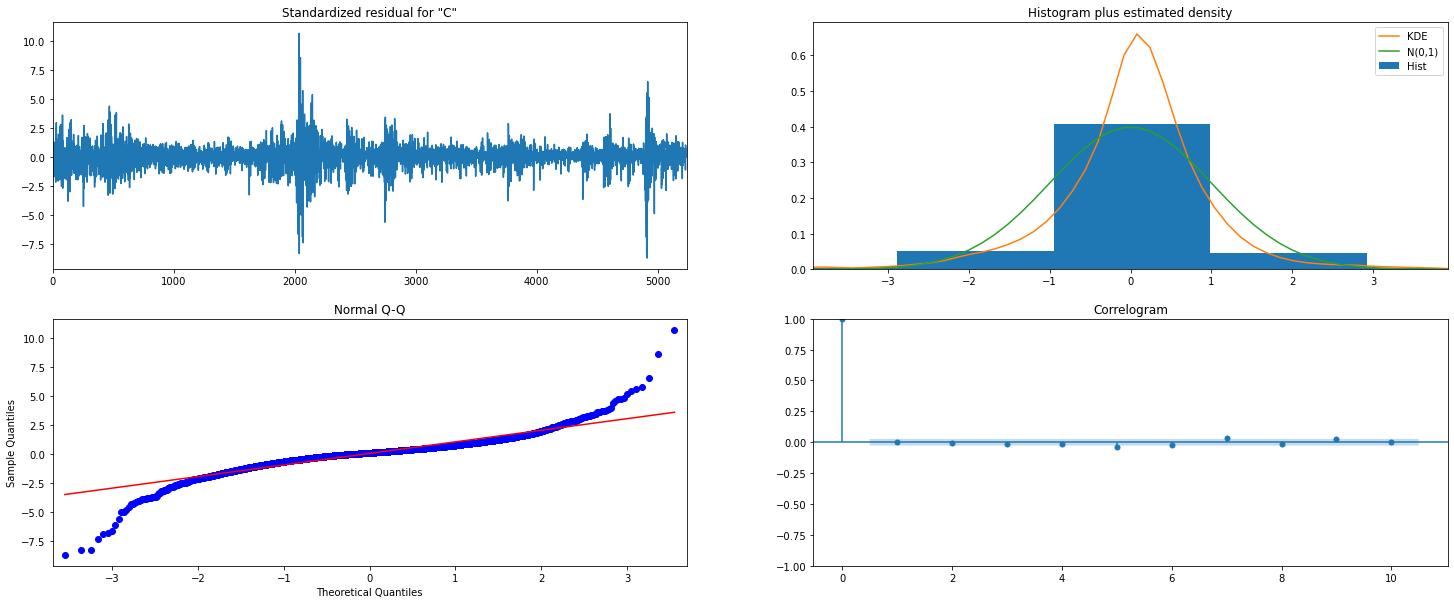

In [16]:
model_arma_result.plot_diagnostics(figsize=(25,10))
plt.show()

In [17]:
#Transform index to date time for the grch model to work

#Estimate a GARCH model for the last model's residuals
model_garch = arch_model(model_arma_result.resid, mean='Zero', p=2, q=1, dist='skewt') #Zero mean to fit residuals from another model
model_garch_result = model_garch.fit(disp = 'off')
print(model_garch_result.summary())

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -6968.27
Distribution:      Standardized Skew Student's t   AIC:                           13948.5
Method:                       Maximum Likelihood   BIC:                           13987.9
                                                   No. Observations:                 5239
Date:                           Tue, Sep 07 2021   Df Residuals:                     5239
Time:                                   16:25:02   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

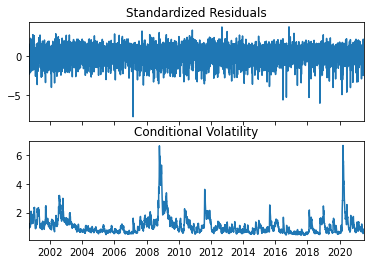

In [18]:
# Plot GARCH model fitted results
model_garch_result.plot()
plt.show()

C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


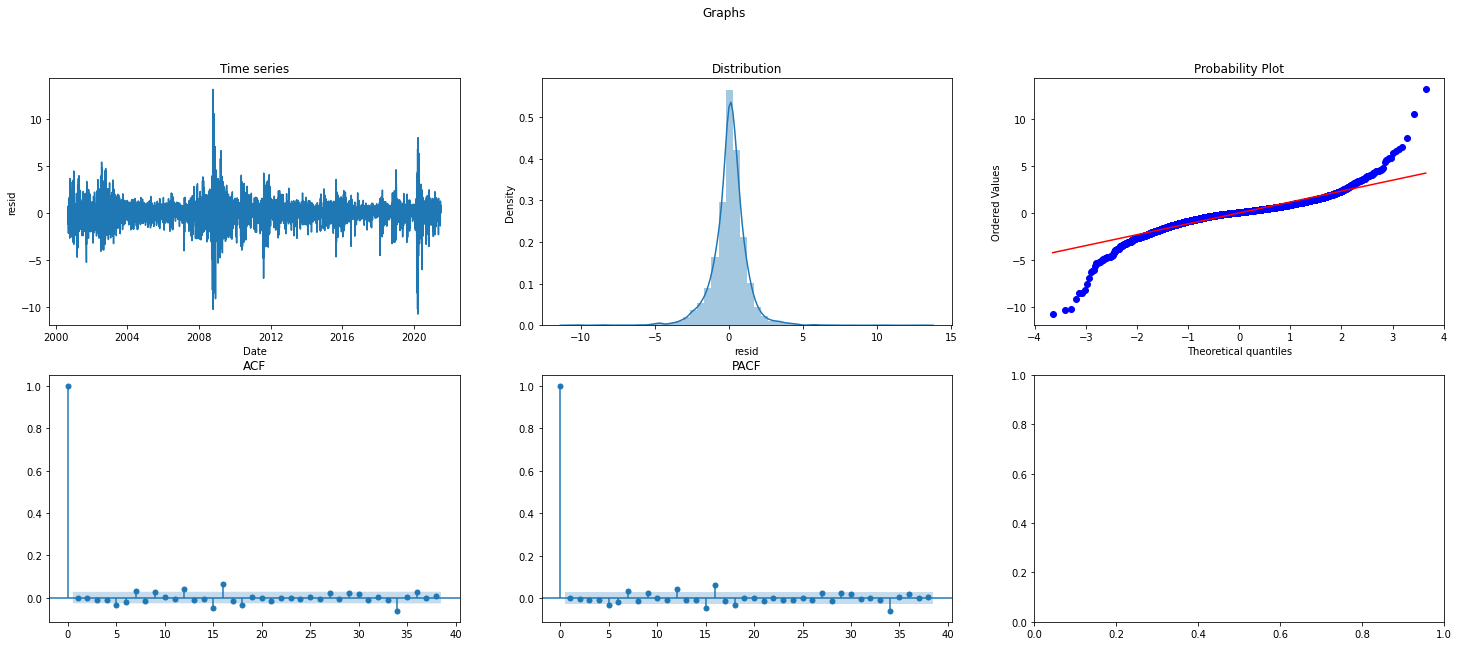

In [19]:
#Graph the model just in case
ts_graph(model_garch_result.resid.dropna(), model_garch_result.resid.dropna().index)


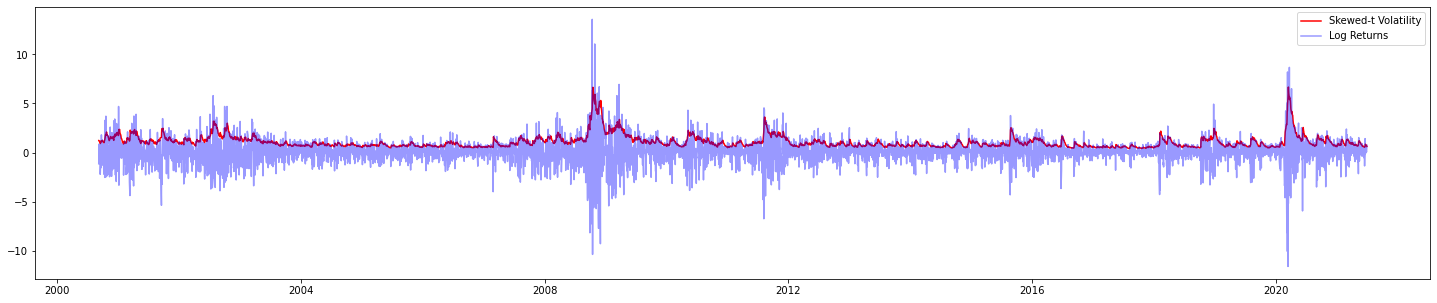

In [24]:
# Plot model fitting results
plt.figure(figsize=(25,5))
plt.plot(model_garch_result.conditional_volatility, color = 'red', label = 'Skewed-t Volatility')
plt.plot(returns_log, color = 'blue', label = 'Log Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

In [21]:
#Rolling Forecast
#returns_log_tot.index = pd.DatetimeIndex(returns_log_tot.index).to_period('D') #Necessary for pmdarima to work
rolling_predictions2 = []
test_size = 60

for i in range(test_size):
    train = returns_log_tot[:-(test_size-i)]

    model_arma = sm.tsa.SARIMAX(train, order = (2,0,1))
    model_arma_result = model_arma.fit()
    
    model = arch_model(model_arma_result.resid, mean='Zero', p=2, q=1, dist='skewt')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = False)
    rolling_predictions2.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions2 = pd.Series(rolling_predictions2, index=returns.index[-60:])

C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Admin\miniconda3\envs\minimal_ds2\lib\site-packages\statsmodels\tsa\base\tsa_model

In [22]:
model_arma_result.resid.index

DatetimeIndex(['2000-09-06', '2000-09-07', '2000-09-08', '2000-09-11',
               '2000-09-12', '2000-09-13', '2000-09-14', '2000-09-15',
               '2000-09-18', '2000-09-19',
               ...
               '2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26',
               '2021-08-27', '2021-08-30', '2021-08-31', '2021-09-01',
               '2021-09-02', '2021-09-03'],
              dtype='datetime64[ns]', name='Date', length=5283, freq=None)

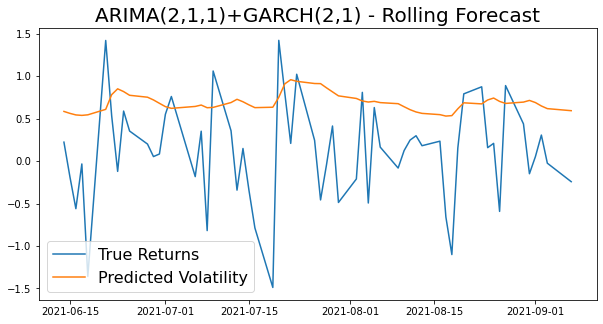

In [23]:
plt.figure(figsize=(10,5))
#returns_log_tot.index = returns_log_tot.index.to_timestamp()
rolling_predictions2.index = pd.DatetimeIndex(rolling_predictions2.index)
true, = plt.plot(returns_log_tot[-60:])
preds, = plt.plot(rolling_predictions2)
plt.title('ARIMA(2,1,1)+GARCH(2,1) - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)
